# Linear Regression **Project**

Based on **Patric Loeber** video: https://www.youtube.com/watch?v=LwM7xabuiIc&t=3543s

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [46]:
# dataset from the year 1983, with different features we predict the MPG for a car (how many miles a car can travel using one gallon of fuel)
# https://archive.ics.uci.edu/ml/datasets/Auto+MPG
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
columns_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                 'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=columns_names, na_values='?',
                      comment='\t', sep=' ', skipinitialspace=True)


In [47]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [48]:
# clean data
dataset = dataset.dropna()

# convert categorical 'Origin' data into one-hot data
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1
dataset['Europe'] = (origin == 2)*1
dataset['Japan'] = (origin == 3)*1

In [49]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


In [50]:
# split the data into train and test
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print(f"Dataset shape: {dataset.shape}, train dataset shape: {train_dataset.shape}, test dataset shape: {test_dataset.shape}")
train_dataset.describe().transpose()

Dataset shape: (392, 10), train dataset shape: (314, 10), test dataset shape: (78, 10)


,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [51]:
# split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [82]:
def plot(feature, x=None, y=None):
    plt.figure(figsize=(8,6))
    plt.scatter(train_features[feature], train_labels, label='Data')
    if x is not None and y is not None:
        plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel(feature)
    plt.ylabel('MPG')
    plt.legend

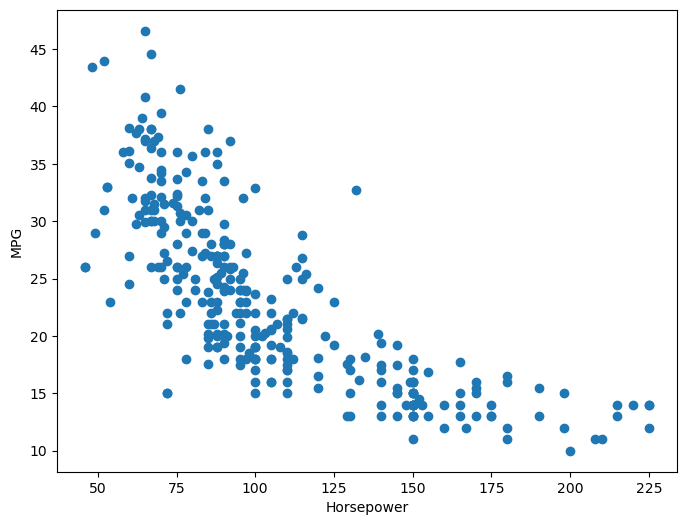

In [83]:
plot('Horsepower')

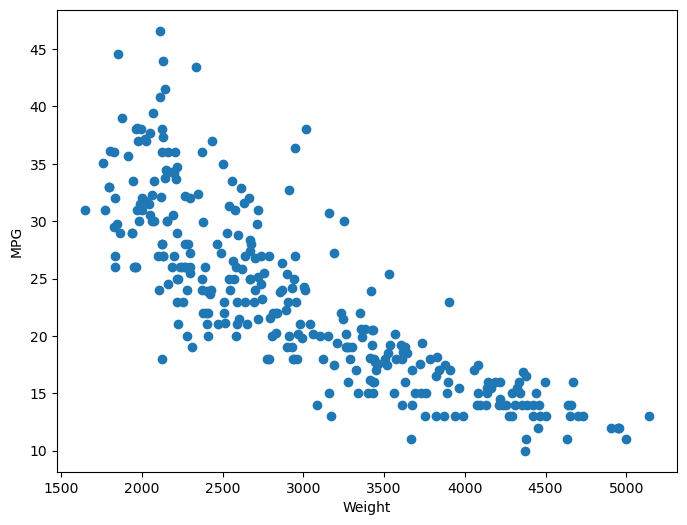

In [85]:
plot('Weight')

In [55]:
# Normalize
# We have different mean values, all the features have different ranges and this is again a very important issue that we have to consider.
# If we leave that different ranges just like they are now then our model might be confused.
# It is recomended to normalize the data first
print(train_dataset.describe().transpose()[['mean', 'std']])

                     mean         std
MPG             23.310510    7.728652
Cylinders        5.477707    1.699788
Displacement   195.318471  104.331589
Horsepower     104.869427   38.096214
Weight        2990.251592  843.898596
Acceleration    15.559236    2.789230
Model Year      75.898089    3.675642
USA              0.624204    0.485101
Europe           0.178344    0.383413
Japan            0.197452    0.398712


In [56]:
# Normalization layer (keras layer for sequential api)
normalizer = preprocessing.Normalization()

# adapt to the data
normalizer.adapt(np.array(train_features)) # calculates mean and variance and store it in the layers
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.624    0.178
     0.197]]


In [57]:
# When the layer is called it returns the input data, with each feature independently normalized:
# (input-mean) / stddev
# this means that our output has a zero mean and unit variance
first = np.array(train_features[:1])
print("First example:", first)
print("Normalized:", normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     1.     0.     0. ]]
Normalized: [[-0.871 -1.011 -0.785 -1.027 -0.38  -0.517  0.776 -0.466 -0.496]]


In [58]:
# Regression (2d case)
# 1. Normalize the input horsepower
# 2. Apply a linear transformation (y = m*x+b) to produce 1 output using layers.Dense()

feature = 'Horsepower'
single_feature = np.array(train_features[feature])
# Reshape single_feature to have a shape of (num_samples, 1)
single_feature = np.reshape(single_feature, (-1,1))
print(single_feature.shape, train_features.shape)

# Normalization
single_feature_normalizer = preprocessing.Normalization(axis=-1)

# Adapt to the data
single_feature_normalizer.adapt(single_feature)


(314, 1) (314, 9)


In [71]:
# Sequential model
single_feature_model = keras.models.Sequential([
    layers.Input(shape=(1,)),
    single_feature_normalizer,
    layers.Dense(units=1)  # Linear model
])

In [72]:
single_feature_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normaliza  multiple                  3         
 tion)                                                           
                                                                 
 dense_6 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [73]:
# loss and optimizer
loss = keras.losses.MeanAbsoluteError() # We can also use MeanSquaredError
optim = keras.optimizers.legacy.Adam(learning_rate=0.1)

single_feature_model.compile(optimizer=optim, loss=loss)

In [75]:
history = single_feature_model.fit(
    train_features[feature], train_labels,
    epochs=100,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split=0.2
)

Epoch 1/100
8/8 [==============================] - 0s 3ms/step - loss: 3.8044 - val_loss: 4.1823
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8024 - val_loss: 4.1930
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8063 - val_loss: 4.1986
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8043 - val_loss: 4.1733
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8052 - val_loss: 4.1948
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8028 - val_loss: 4.1893
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8030 - val_loss: 4.1944
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8063 - val_loss: 4.2053
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8055 - val_loss: 4.1883
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8040 - val_loss: 4.1760
Epoch 11/100
8/8 [===========

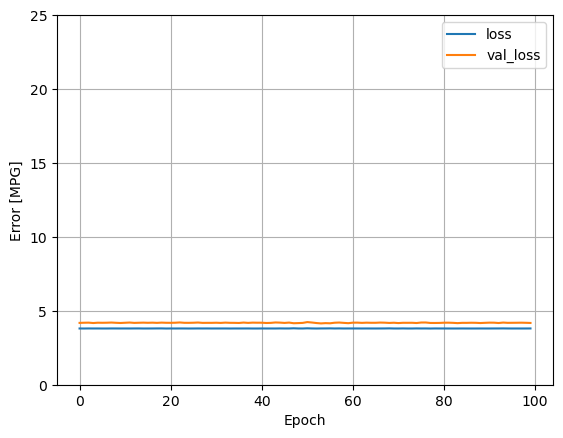

In [76]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 25])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
plot_loss(history)

In [77]:
single_feature_model.evaluate(
    test_features[feature],
    test_labels, verbose=1
)

3/3 [==============================] - 0s 824us/step - loss: 3.6474


3.647366762161255

7/7 [==============================] - 0s 397us/step


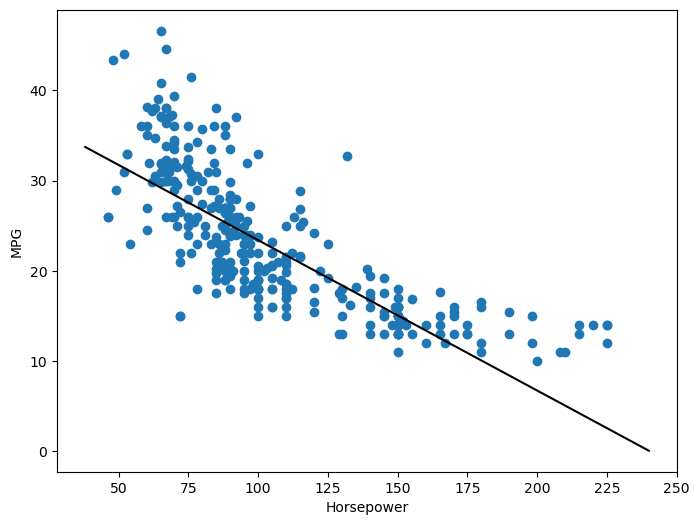

In [86]:
# predict and plot
range_min = np.min(test_features[feature]) - 10
range_max = np.max(test_features[feature]) + 10
x = tf.linspace(range_min, range_max, 200)
y = single_feature_model.predict(x[:, tf.newaxis])

plot(feature, x,y)

In [88]:
# Deep Neural Network, we converted our linear model to a deep neural network by adding two more layers
dnn_model = keras.Sequential([
    layers.Input(shape=(1,)),  # Specify input shape
    single_feature_normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [89]:
dnn_model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(0.001))

dnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normaliza  multiple                  3         
 tion)                                                           
                                                                 
 dense_10 (Dense)            (None, 64)                128       
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4356 (17.02 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [90]:
dnn_model.fit(
    train_features[feature], train_labels,
    validation_split=0.2,
    verbose=1, epochs=1000
)

Epoch 1/1000
8/8 [==============================] - 0s 7ms/step - loss: 23.1084 - val_loss: 23.4749
Epoch 2/1000
8/8 [==============================] - 0s 2ms/step - loss: 22.8455 - val_loss: 23.1749
Epoch 3/1000
8/8 [==============================] - 0s 2ms/step - loss: 22.5471 - val_loss: 22.8392
Epoch 4/1000
8/8 [==============================] - 0s 2ms/step - loss: 22.2132 - val_loss: 22.4471
Epoch 5/1000
8/8 [==============================] - 0s 2ms/step - loss: 21.8094 - val_loss: 21.9595
Epoch 6/1000
8/8 [==============================] - 0s 2ms/step - loss: 21.2957 - val_loss: 21.3442
Epoch 7/1000
8/8 [==============================] - 0s 2ms/step - loss: 20.6295 - val_loss: 20.5525
Epoch 8/1000
8/8 [==============================] - 0s 2ms/step - loss: 19.7925 - val_loss: 19.5422
Epoch 9/1000
8/8 [==============================] - 0s 2ms/step - loss: 18.7387 - val_loss: 18.3487
Epoch 10/1000
8/8 [==============================] - 0s 2ms/step - loss: 17.5381 - val_loss: 17.0141

In [91]:
dnn_model.evaluate(test_features[feature], test_labels, verbose=1)

3/3 [==============================] - 0s 1ms/step - loss: 2.7573


2.7573482990264893

7/7 [==============================] - 0s 484us/step


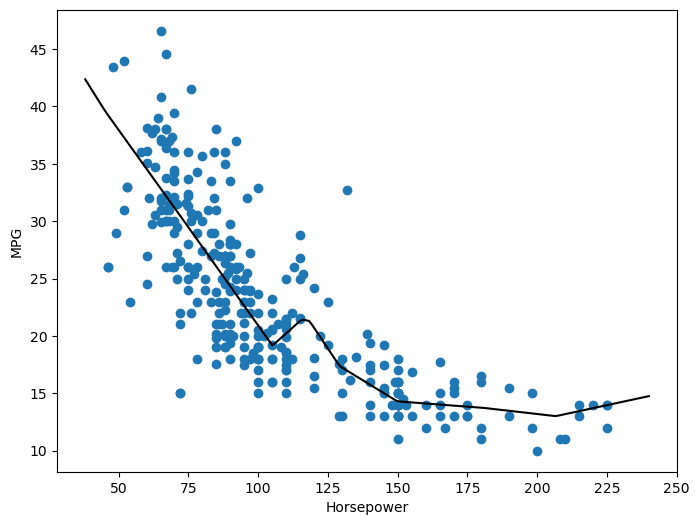

In [92]:
# predict and plot
x = tf.linspace(range_min, range_max, 200)
y = dnn_model.predict(x)

plot(feature, x,y)

In [94]:
# multiple inputs
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.compile(
    optimizer=tf.optimizers.legacy.Adam(learning_rate=0.1),
    loss=loss
)

In [95]:
linear_model.fit(
    train_features, train_labels,
    epochs=100,
    verbose=1,
    # Calculate validation results on 20`5 of the training data
    validation_split=0.2
)

Epoch 1/100
8/8 [==============================] - 0s 7ms/step - loss: 22.8676 - val_loss: 23.1456
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 22.0190 - val_loss: 22.4273
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 21.1956 - val_loss: 21.6783
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 20.3822 - val_loss: 20.9435
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 19.5624 - val_loss: 20.2081
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 18.7407 - val_loss: 19.4631
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 17.9241 - val_loss: 18.7296
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 17.1166 - val_loss: 18.0354
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 16.3597 - val_loss: 17.3948
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 15.5058 - val_loss: 16.5794
Epoch 11/

In [96]:
linear_model.evaluate(
    test_features, test_labels, verbose=1)

3/3 [==============================] - 0s 812us/step - loss: 2.5199


2.519946336746216